In [736]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [737]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [738]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

c:\Users\vasja\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\vasja\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\vasja\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\vasja\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [739]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [740]:
X_train = X_train.float()
X_test = X_test.float()

In [741]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [742]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

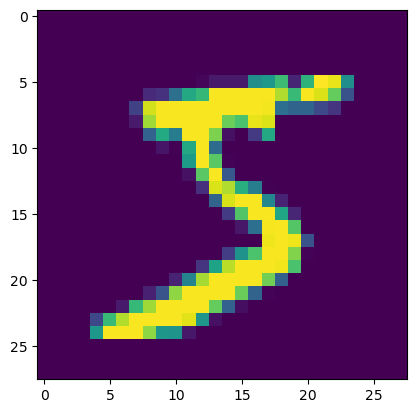

tensor(5)


In [743]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [744]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [745]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(784)

In [746]:
torch.cuda.is_available()

True

In [747]:
!nvidia-smi

Wed Mar 12 19:50:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 49%   64C    P0             N/A /   75W |    3833MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [748]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mnist_net = mnist_net.to(device)
list(mnist_net.parameters())


[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0222, -0.0173,  0.0321,  ..., -0.0006,  0.0226, -0.0265],
         [ 0.0306,  0.0002, -0.0134,  ..., -0.0233,  0.0153,  0.0097],
         [-0.0053, -0.0092, -0.0087,  ..., -0.0200, -0.0275, -0.0332]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 4.5107e-03,  2.5021e-02,  2.1503e-02,  4.0661e-03, -2.6127e-02,
         -3.3030e-02,  6.4560e-03,  7.7034e-03, -9.2830e-03,  2.2907e-02,
         -1.5615e-02,  1.7417e-02, -3.0968e-02, -6.9395e-03,  4.2131e-03,
          2.9178e-02, -1.4501e-02, -2.6742e-02, -1.1398e-02,  2.5563e-02,
          2.2813e-02,  1.4460e-02, -2.5614e-03, -1.9794e-02, -3.2585e-02,
          1.0069e-02,  2.8883e-02, -5.9107e-03,  1.4734e-02,  3.2826e-02,
         -3.2128e-02, -

In [749]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_net.parameters(), lr=9.0e-3, momentum=0.93)

In [750]:
batch_size = 500

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(30):
    order = np.random.permutation(len(X_train))
    epoch_train_loss = []
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        epoch_train_loss.append(loss_value.detach())

    train_loss_history.append(torch.mean(torch.stack(epoch_train_loss))) #Усредняем батчи и добавляем в историю


    with torch.no_grad():  # Отключаем вычисление градиентов для теста
        test_preds = mnist_net.forward(X_test)
        test_loss = loss(test_preds, y_test) #считаем вне цикла
        test_loss_history.append(test_loss)

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
        test_accuracy_history.append(accuracy)
        print(accuracy)

tensor(0.9269, device='cuda:0')
tensor(0.9413, device='cuda:0')
tensor(0.9505, device='cuda:0')
tensor(0.9545, device='cuda:0')
tensor(0.9595, device='cuda:0')
tensor(0.9619, device='cuda:0')
tensor(0.9636, device='cuda:0')
tensor(0.9652, device='cuda:0')
tensor(0.9677, device='cuda:0')
tensor(0.9691, device='cuda:0')
tensor(0.9703, device='cuda:0')
tensor(0.9714, device='cuda:0')
tensor(0.9712, device='cuda:0')
tensor(0.9739, device='cuda:0')
tensor(0.9744, device='cuda:0')
tensor(0.9731, device='cuda:0')
tensor(0.9734, device='cuda:0')
tensor(0.9730, device='cuda:0')
tensor(0.9744, device='cuda:0')
tensor(0.9751, device='cuda:0')
tensor(0.9754, device='cuda:0')
tensor(0.9762, device='cuda:0')
tensor(0.9757, device='cuda:0')
tensor(0.9753, device='cuda:0')
tensor(0.9773, device='cuda:0')
tensor(0.9780, device='cuda:0')
tensor(0.9768, device='cuda:0')
tensor(0.9771, device='cuda:0')
tensor(0.9785, device='cuda:0')
tensor(0.9784, device='cuda:0')


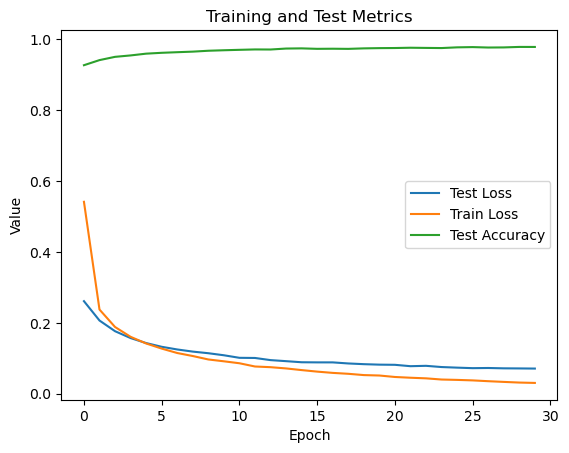

In [751]:
# Обработка test_loss_history
if isinstance(test_loss_history, list) and all(isinstance(item, torch.Tensor) for item in test_loss_history):
    test_loss_history_cpu = [loss.cpu().detach().numpy() for loss in test_loss_history]
    plt.plot(test_loss_history_cpu, label="Test Loss")
elif isinstance(test_loss_history, torch.Tensor):
    test_loss_history_cpu = test_loss_history.cpu().detach().numpy()
    plt.plot(test_loss_history_cpu, label="Test Loss")
else:
    plt.plot(test_loss_history, label="Test Loss")


# Обработка train_loss_history
if isinstance(train_loss_history, list) and all(isinstance(item, torch.Tensor) for item in train_loss_history):
    train_loss_history_cpu = [loss.cpu().detach().numpy() for loss in train_loss_history]
    plt.plot(train_loss_history_cpu, label="Train Loss")
elif isinstance(train_loss_history, torch.Tensor):
    train_loss_history_cpu = train_loss_history.cpu().detach().numpy()
    plt.plot(train_loss_history_cpu, label='Train Loss')
else:
    plt.plot(train_loss_history, label="Train Loss")

# Обработка test_accuracy_history (если нужно)
if isinstance(test_accuracy_history, list) and all(isinstance(item, torch.Tensor) for item in test_accuracy_history):
    test_accuracy_history_cpu = [acc.cpu().detach().numpy() for acc in test_accuracy_history]
    plt.plot(test_accuracy_history_cpu, label="Test Accuracy")
elif isinstance(test_accuracy_history, torch.Tensor):
    test_accuracy_history_cpu = test_accuracy_history.cpu().detach().numpy()
    plt.plot(test_accuracy_history_cpu, label="Test Accuracy")
else:
    plt.plot(test_accuracy_history, label="Test Accuracy")


plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training and Test Metrics")
plt.legend()
plt.show()

Epoch 1, Val Loss: 0.3093, Train Loss: 1.4128
Epoch 2, Val Loss: 0.1941, Train Loss: 0.2325
Epoch 3, Val Loss: 0.1625, Train Loss: 0.1589
Epoch 4, Val Loss: 0.1240, Train Loss: 0.1257
Epoch 5, Val Loss: 0.1299, Train Loss: 0.1077
Epoch 6, Val Loss: 0.1175, Train Loss: 0.0957
Epoch 7, Val Loss: 0.1115, Train Loss: 0.0821
Epoch 8, Val Loss: 0.0986, Train Loss: 0.0709
Epoch 9, Val Loss: 0.1004, Train Loss: 0.0665
Epoch 10, Val Loss: 0.0986, Train Loss: 0.0602
Epoch 11, Val Loss: 0.0987, Train Loss: 0.0528
Epoch 12, Val Loss: 0.0956, Train Loss: 0.0504
Epoch 13, Val Loss: 0.0874, Train Loss: 0.0483
Epoch 14, Val Loss: 0.0887, Train Loss: 0.0474
Epoch 15, Val Loss: 0.0967, Train Loss: 0.0429
Epoch 16, Val Loss: 0.0936, Train Loss: 0.0433
Epoch 17, Val Loss: 0.0917, Train Loss: 0.0452
Early stopping on epoch 18
Test Accuracy: 0.9753, Test Loss: 0.0988


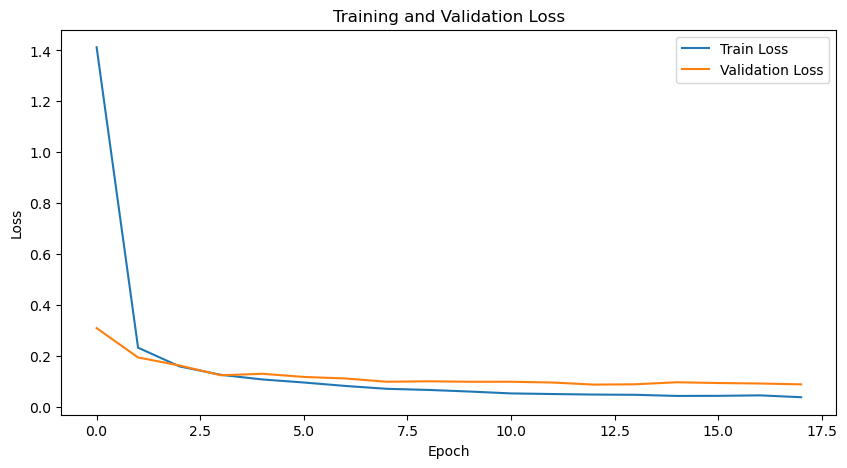

In [752]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# --- Воспроизводимость ---
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# --- Загрузка и предобработка данных ---
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST('./', train=False, download=True, transform=test_transform)

X = train_dataset.data.float() # Все данные для обучения
y = train_dataset.targets

# Разделение на train/val/test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


# --- Модель (CNN) ---
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

mnist_net = MNIST_CNN()

# --- Выбор устройства ---
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net.to(device)


# --- Функция потерь и оптимизатор ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_net.parameters(), lr=1e-3)

# --- Обучение ---
batch_size = 500
num_epochs = 30  # Можете увеличить
patience = 5
best_val_loss = float('inf')
best_model_state = None

train_loss_history = []
val_loss_history = []


X_val = X_val.unsqueeze(1).to(device) # Добавляем размерность канала и перемещаем на GPU
y_val = y_val.to(device)
X_test = X_test.unsqueeze(1).to(device)
y_test = y_test.to(device)


for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    epoch_train_loss = []

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes].unsqueeze(1).to(device)  # Добавляем размерность канала
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net(X_batch)
        loss_value = loss_fn(preds, y_batch)
        loss_value.backward()
        optimizer.step()
        epoch_train_loss.append(loss_value.item()) # .item() - чтобы получить число

    train_loss_history.append(np.mean(epoch_train_loss)) #среднее значение loss по эпохе



    with torch.no_grad():
        val_preds = mnist_net(X_val)
        val_loss = loss_fn(val_preds, y_val).item() # .item() - чтобы получить число
        val_loss_history.append(val_loss)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = mnist_net.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping on epoch {epoch+1}")
                break

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Train Loss: {train_loss_history[-1]:.4f}")



# Загружаем лучшие веса
mnist_net.load_state_dict(best_model_state)


# Оценка на тестовой выборке
with torch.no_grad():
    test_preds = mnist_net(X_test)
    test_loss = loss_fn(test_preds, y_test)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()

print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}")

# --- Построение графиков ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()